In [1]:
#Import required libraries

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import cv2


In [68]:
#Check for GPU CPU
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else:
    device= torch.device("cpu")
    print("Device is: ",device)



Device is:  cpu


# Input image with boundingbox and Labels on objects

Input Image Shape (H,W,F):  (500, 326, 3)


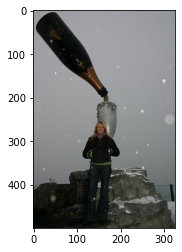

In [67]:
#Diplay Input Image
input_img = cv2.imread(r'C:\Users\Owner\Downloads\000498.jpg')
input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB) 
print("Input Image Shape (H,W,F): ",input_img.shape)
plt.imshow(input_img)
plt.show()

In [69]:
#We have the bounding box information in annotations xml file
# Object information: a set of bounding boxes [ymin, xmin, ymax, xmax] and their labels 
bounding_box = np.array([[5, 6, 203, 176], [256, 114, 496, 201]]) 
labels = np.array([0, 1]) # 0: bottle, 1: person


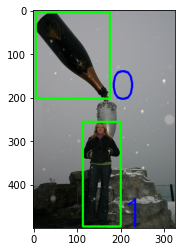

In [71]:
#Display bounding box and lables with respect to objects
img_clone = np.copy(input_img)
for i in range(len(bounding_box)):
    cv2.rectangle(img_clone, (bounding_box[i][1], bounding_box[i][0]), (bounding_box[i][3], bounding_box[i][2]), color=(0, 255, 0), thickness=3) 
    cv2.putText(img_clone, str(int(labels[i])), (bounding_box[i][3], bounding_box[i][2]), cv2.FONT_HERSHEY_SIMPLEX, 3, (0,0,255),thickness=3) 
plt.imshow(img_clone)
plt.show()    

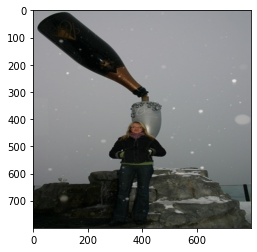

In [73]:
#Resize the input image to (h=800, w=800) for providing to vggnet
img = cv2.resize(input_img, dsize=(800, 800))
plt.imshow(img)
plt.show()

In [76]:
# change the bounding box coordinates according to resize of input image
Wratio = 800/input_img.shape[1]
Hratio = 800/input_img.shape[0]
ratioLst = [Hratio, Wratio, Hratio, Wratio]
bbox = []
for box in bounding_box:
    box = [int(a * b) for a, b in zip(box, ratioLst)] 
    bbox.append(box)
bbox = np.array(bbox)
print("Resized Boundingbox coordinates: \n",bbox)

Resized Boundingbox coordinates: 
 [[  8  14 324 431]
 [409 279 793 493]]


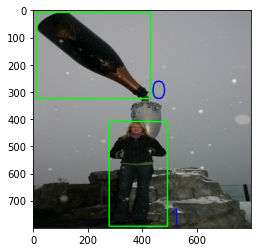

In [77]:
# display bounding box and labels after resized
img_clone = np.copy(img)
bbox_clone = bbox.astype(int)
for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][1], bbox[i][0]), (bbox[i][3], bbox[i][2]), color=(0, 255, 0), thickness=3) # Draw Rectangle
    cv2.putText(img_clone, str(int(labels[i])), (bbox[i][3], bbox[i][2]), cv2.FONT_HERSHEY_SIMPLEX, 3, (0,0,255),thickness=3) # Write the prediction class
plt.imshow(img_clone)
plt.show()  

# VGG16 for Features Extraction from Image

Input Image size: Batchsize= 1, H = 800, W = 800, d=3
FeatureMap size: Batchsize= 1, H=50 , W=50, d=512

In [9]:

# List all the layers of VGG16
model = torchvision.models.vgg16(pretrained=True).to(device)
fe = list(model.features)
print(len(fe))


31


In [10]:
fe

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1

In [97]:
# collect layers with output feature map size (W, H) < 50
# test image of size [1, 3, 800, 800] 
dummy_img = torch.zeros((1, 3, 800, 800)).float()
print(dummy_img.shape)

req_features = []
k = dummy_img.clone().to(device)
for i in fe:
    k = i(k)
    if k.size()[2] < 800//16:
        break
    req_features.append(i)
    out_channels = k.size()[1]
print("Size of Required Features: ",len(req_features))
print("Number of output channels",out_channels)

torch.Size([1, 3, 800, 800])
Size of Required Features:  30
Number of output channels 512


In [79]:
# Buid a Sequential module with required features
faster_rcnn_fe_extractor = nn.Sequential(*req_features)

In [80]:
# FatureMap  is created with vgg16 sequential model
transform = transforms.Compose([transforms.ToTensor()]) # Defing PyTorch Transform
imgTensor = transform(img).to(device) 
imgTensor = imgTensor.unsqueeze(0)
out_map = faster_rcnn_fe_extractor(imgTensor)
print("Featuremap Output size:",out_map.size())

Featuremap Output size: torch.Size([1, 512, 50, 50])


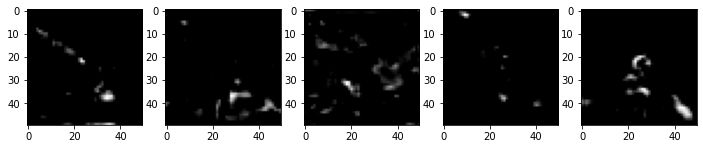

In [81]:
# visualize the first 5 channels of the feature maps
imageArray=out_map.data.cpu().numpy().squeeze(0)
fig=plt.figure(figsize=(12, 4))
figNo = 1
for i in range(5): 
    fig.add_subplot(1, 5, figNo) 
    plt.imshow(imageArray[i], cmap='gray')
    figNo +=1
plt.show()


# Create Anchorboxes on Input Image

In [82]:
# Generate a total of  50*50*9 = 2500*9 = 22500 anchorboxes on an image.
#for an image of 50x50 2500 anchors on each anchor 9 anchor boxes(3ratios * 3Scales)

ratios = [0.5, 1, 2]
scales = [8, 16, 32]
sub_sample = 16

# x, y intervals to generate anchor box center
fe_size = (800//16)
ctr_x = np.arange(16, (fe_size+1) * 16, 16)
ctr_y = np.arange(16, (fe_size+1) * 16, 16)
print("CenterX:\n", len(ctr_x), ctr_x)
print("CenterY:\n", len(ctr_y), ctr_y)


CenterX:
 50 [ 16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 272 288
 304 320 336 352 368 384 400 416 432 448 464 480 496 512 528 544 560 576
 592 608 624 640 656 672 688 704 720 736 752 768 784 800]
CenterY:
 50 [ 16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 272 288
 304 320 336 352 368 384 400 416 432 448 464 480 496 512 528 544 560 576
 592 608 624 640 656 672 688 704 720 736 752 768 784 800]


In [83]:
# coordinates of the 2500 center points to generate anchor boxes
index = 0
ctr = np.zeros((2500, 2))
for x in range(len(ctr_x)):
    for y in range(len(ctr_y)):
        ctr[index, 1] = ctr_x[x] - 8
        ctr[index, 0] = ctr_y[y] - 8
        index +=1
print(ctr.shape)


(2500, 2)


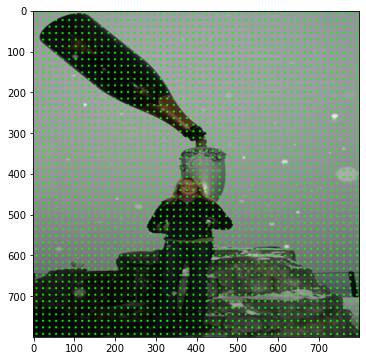

In [84]:
# display the 2500 anchors
image_clone = np.copy(img)
plt.figure(figsize=(9, 6))
for i in range(ctr.shape[0]):
    cv2.circle(image_clone, (int(ctr[i][0]), int(ctr[i][1])), radius=1, color=(0, 255, 0), thickness=2) 
plt.imshow(image_clone)
plt.show()    


In [18]:
#get anchor box with 4 coordinates [ymin, xmin, ymax, xmax]
anchor_boxes = np.zeros( ((fe_size * fe_size * 9), 4))
index = 0
for c in ctr:
    ctr_y, ctr_x = c
    for i in range(len(ratios)):
        for j in range(len(scales)):
            h = sub_sample * scales[j] * np.sqrt(ratios[i])
            w = sub_sample * scales[j] * np.sqrt(1./ ratios[i])
            anchor_boxes[index, 0] = ctr_y - h / 2.
            anchor_boxes[index, 1] = ctr_x - w / 2.
            anchor_boxes[index, 2] = ctr_y + h / 2.
            anchor_boxes[index, 3] = ctr_x + w / 2.
            index += 1
print(anchor_boxes.shape)

(22500, 4)


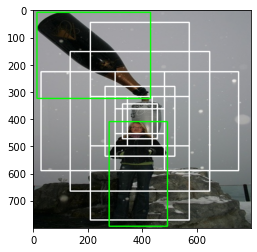

In [86]:
# display the 9 anchor boxes of one anchor and the ground trugth boundingboxes

img_clone = np.copy(img)
for i in range(11025, 11034):
    x0 = int(anchor_boxes[i][1])
    y0 = int(anchor_boxes[i][0])
    x1 = int(anchor_boxes[i][3])
    y1 = int(anchor_boxes[i][2])
    cv2.rectangle(img_clone, (x0, y0), (x1, y1), color=(255, 255, 255), thickness=3) 

for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][1], bbox[i][0]), (bbox[i][3], bbox[i][2]), color=(0, 255, 0), thickness=3) # Draw Rectangle
    
plt.imshow(img_clone)
plt.show()  


In [87]:
# Get valid anchor boxes(Inside image) with (y1, x1)>0 and (y2, x2)<=800
index_inside = np.where(
        (anchor_boxes[:, 0] >= 0) &
        (anchor_boxes[:, 1] >= 0) &
        (anchor_boxes[:, 2] <= 800) &
        (anchor_boxes[:, 3] <= 800)
    )[0]
print(index_inside.shape)

valid_anchor_boxes = anchor_boxes[index_inside]
print(valid_anchor_boxes.shape)

(8940,)
(8940, 4)


In [88]:
# Calculate iou of the valid anchor boxes 
# Since we have 8940 anchor boxes and 2 ground truth objects, we should get an array with (8490, 2) as the output. 
ious = np.empty((len(valid_anchor_boxes), 2), dtype=np.float32)
ious.fill(0)
for num1, i in enumerate(valid_anchor_boxes):
    ya1, xa1, ya2, xa2 = i  
    anchor_area = (ya2 - ya1) * (xa2 - xa1)
    for num2, j in enumerate(bbox):
        yb1, xb1, yb2, xb2 = j
        box_area = (yb2- yb1) * (xb2 - xb1)
        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = min([xb2, xa2])
        inter_y2 = min([yb2, ya2])
        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            iter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
            iou = iter_area / (anchor_area+ box_area - iter_area)            
        else:
            iou = 0.
        ious[num1, num2] = iou
print(ious.shape)

(8940, 2)


In [89]:
# What anchor box has max iou with the ground truth bbox  
gt_argmax_ious = ious.argmax(axis=0)
print(gt_argmax_ious)

gt_max_ious = ious[gt_argmax_ious, np.arange(ious.shape[1])]
print(gt_max_ious)

gt_argmax_ious = np.where(ious == gt_max_ious)[0]
print(gt_argmax_ious)


[2262 4160]
[0.5026703  0.79750776]
[2262 3952 4160 4434]


In [90]:
# What ground truth bbox is associated with each anchor box 
argmax_ious = ious.argmax(axis=1)
print(argmax_ious.shape)
print(argmax_ious)
max_ious = ious[np.arange(len(index_inside)), argmax_ious]
print(max_ious)

(8940,)
[0 0 0 ... 0 0 0]
[0.11933114 0.11933114 0.11933114 ... 0.         0.         0.        ]


In [91]:
#8940 valid anchor boxes -1 (ignore)
label = np.empty((len(index_inside), ), dtype=np.int32)
label.fill(-1)
print(label.shape)


(8940,)


# RPN TRAINING

In [92]:
#Assign 1 to Object
# Use iou to assign 1 (objects) to two kind of anchors 
# 1. The anchors with the highest iou overlap with a ground-truth-box
# 2. An anchor that has an IoU overlap higher than 0.7 with ground-truth box
pos_iou_threshold  = 0.7
neg_iou_threshold = 0.3
label[gt_argmax_ious] = 1
label[max_ious >= pos_iou_threshold] = 1

#Assign 0 to Background
#anchor if its IoU ratio is lower than 0.3 for all ground-truth boxes
label[max_ious < neg_iou_threshold] = 0

In [93]:

n_sample = 256
pos_ratio = 0.5
n_pos = pos_ratio * n_sample

pos_index = np.where(label == 1)[0]
if len(pos_index) > n_pos:
    disable_index = np.random.choice(pos_index, size=(len(pos_index) - n_pos), replace=False)
    label[disable_index] = -1
    
n_neg = n_sample * np.sum(label == 1)
neg_index = np.where(label == 0)[0]
if len(neg_index) > n_neg:
    disable_index = np.random.choice(neg_index, size=(len(neg_index) - n_neg), replace = False)
    label[disable_index] = -1

In [94]:

# For each valid anchor box, find the groundtruth object which has max_iou 
max_iou_bbox = bbox[argmax_ious]
print(max_iou_bbox.shape)

# valid anchor boxes h, w, cx, cy 
height = valid_anchor_boxes[:, 2] - valid_anchor_boxes[:, 0]
width = valid_anchor_boxes[:, 3] - valid_anchor_boxes[:, 1]
ctr_y = valid_anchor_boxes[:, 0] + 0.5 * height
ctr_x = valid_anchor_boxes[:, 1] + 0.5 * width

# valid anchor box h, w, cx, cy 
base_height = max_iou_bbox[:, 2] - max_iou_bbox[:, 0]
base_width = max_iou_bbox[:, 3] - max_iou_bbox[:, 1]
base_ctr_y = max_iou_bbox[:, 0] + 0.5 * base_height
base_ctr_x = max_iou_bbox[:, 1] + 0.5 * base_width

# valid anchor boxes = (y-ya/ha), (x-xa/wa), log(h/ha), log(w/wa)
eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)
dy = (base_ctr_y - ctr_y) / height
dx = (base_ctr_x - ctr_x) / width
dh = np.log(base_height / height)
dw = np.log(base_width / width)
anchor_locs = np.vstack((dy, dx, dh, dw)).transpose()
print(anchor_locs.shape)

(8940, 4)
(8940, 4)


In [95]:
anchor_labels = np.empty((len(anchor_boxes),), dtype=label.dtype)
anchor_labels.fill(-1)
anchor_labels[index_inside] = label
print(anchor_labels.shape)

anchor_locations = np.empty((len(anchor_boxes),) + anchor_boxes.shape[1:], dtype=anchor_locs.dtype)
anchor_locations.fill(0)
anchor_locations[index_inside, :] = anchor_locs
print(anchor_locations.shape)

(22500,)
(22500, 4)


In [96]:
#define Convolutins layers
in_channels = 512 # depends on the output feature map. in vgg 16 it is equal to 512
mid_channels = 512
n_anchor = 9  # Number of anchors at each location

conv1 = nn.Conv2d(in_channels, mid_channels, 3, 1, 1).to(device)
conv1.weight.data.normal_(0, 0.01)
conv1.bias.data.zero_()

#Regression layer for boundingboxes
reg_layer = nn.Conv2d(mid_channels, n_anchor *4, 1, 1, 0).to(device)
reg_layer.weight.data.normal_(0, 0.01)
reg_layer.bias.data.zero_()

#Classification layer for boundingboxes
cls_layer = nn.Conv2d(mid_channels, n_anchor *2, 1, 1, 0).to(device)
cls_layer.weight.data.normal_(0, 0.01)
cls_layer.bias.data.zero_()


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [98]:
#provide Featuremap as input and call CNN layers.
x = conv1(out_map.to(device))
pred_anchor_locs = reg_layer(x)
pred_cls_scores = cls_layer(x)
print(pred_anchor_locs.shape, pred_cls_scores.shape)

torch.Size([1, 36, 50, 50]) torch.Size([1, 18, 50, 50])


In [99]:

pred_anchor_locs = pred_anchor_locs.permute(0, 2, 3, 1).contiguous().view(1, -1, 4)
print(pred_anchor_locs.shape)

pred_cls_scores = pred_cls_scores.permute(0, 2, 3, 1).contiguous()
print(pred_cls_scores.shape)

objectness_score = pred_cls_scores.view(1, 50, 50, 9, 2)[:, :, :, :, 1].contiguous().view(1, -1)
print(objectness_score.shape)

pred_cls_scores  = pred_cls_scores.view(1, -1, 2)
print(pred_cls_scores.shape)

torch.Size([1, 22500, 4])
torch.Size([1, 50, 50, 18])
torch.Size([1, 22500])
torch.Size([1, 22500, 2])


In [100]:
print(pred_anchor_locs.shape)
print(pred_cls_scores.shape)
print(anchor_locations.shape)
print(anchor_labels.shape)

torch.Size([1, 22500, 4])
torch.Size([1, 22500, 2])
(22500, 4)
(22500,)


In [101]:

rpn_loc = pred_anchor_locs[0]
rpn_score = pred_cls_scores[0]

gt_rpn_loc = torch.from_numpy(anchor_locations)
gt_rpn_score = torch.from_numpy(anchor_labels)

print(rpn_loc.shape, rpn_score.shape, gt_rpn_loc.shape, gt_rpn_score.shape)



torch.Size([22500, 4]) torch.Size([22500, 2]) torch.Size([22500, 4]) torch.Size([22500])


In [102]:

# For classification we use cross-entropy loss
rpn_cls_loss = F.cross_entropy(rpn_score, gt_rpn_score.long().to(device), ignore_index = -1)
print(rpn_cls_loss)

tensor(0.6896, grad_fn=<NllLossBackward>)


In [103]:

# For Regression we use smooth L1 loss as defined in the Fast RCNN paper
pos = gt_rpn_score > 0
mask = pos.unsqueeze(1).expand_as(rpn_loc)
print(mask.shape)

# take those bounding boxes which have positve labels
mask_loc_preds = rpn_loc[mask].view(-1, 4)
mask_loc_targets = gt_rpn_loc[mask].view(-1, 4)
print(mask_loc_preds.shape, mask_loc_targets.shape)

x = torch.abs(mask_loc_targets.cpu() - mask_loc_preds.cpu())
rpn_loc_loss = ((x < 1).float() * 0.5 * x**2) + ((x >= 1).float() * (x-0.5))
print(rpn_loc_loss.sum())


torch.Size([22500, 4])
torch.Size([16, 4]) torch.Size([16, 4])
tensor(0.6126, dtype=torch.float64, grad_fn=<SumBackward0>)


In [104]:
# Combining both the rpn_cls_loss and rpn_reg_loss
rpn_lambda = 10.
N_reg = (gt_rpn_score >0).float().sum()
rpn_loc_loss = rpn_loc_loss.sum() / N_reg
rpn_loss = rpn_cls_loss + (rpn_lambda * rpn_loc_loss)
print(rpn_loss)

tensor(1.0725, dtype=torch.float64, grad_fn=<AddBackward0>)


# ROI

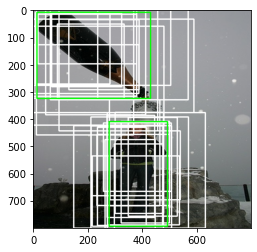

In [47]:
# display ROI samples with postive 
img_clone = np.copy(img)
for i in range(pos_roi_per_this_image):
    y0, x0, y1, x1 = roi[pos_index[i]].astype(int)
    cv2.rectangle(img_clone, (x0, y0), (x1, y1), color=(255, 255, 2550), thickness=3) 

for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][1], bbox[i][0]), (bbox[i][3], bbox[i][2]), color=(0, 255, 0), thickness=3) # Draw Rectangle
    
plt.imshow(img_clone)
plt.show()  



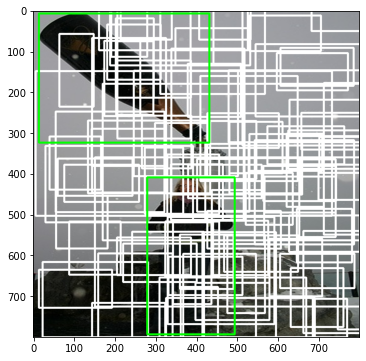

In [48]:

# display ROI samples with negative 
img_clone = np.copy(img)
plt.figure(figsize=(9, 6))
for i in range(neg_roi_per_this_image):
    y0, x0, y1, x1 = roi[neg_index[i]].astype(int)
    cv2.rectangle(img_clone, (x0, y0), (x1, y1), color=(255, 255, 2550), thickness=3) 

for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][1], bbox[i][0]), (bbox[i][3], bbox[i][2]), color=(0, 255, 0), thickness=3) # Draw Rectangle
    
plt.imshow(img_clone)
plt.show()  


# Feed forward layer

In [57]:

roi_head_classifier = nn.Sequential(*[nn.Linear(25088, 4096), nn.Linear(4096, 4096)]).to(device)
cls_loc = nn.Linear(4096, 2 * 4).to(device)
cls_loc.weight.data.normal_(0, 0.01)
cls_loc.bias.data.zero_()
score = nn.Linear(4096, 2).to(device)

# passing the output of roi-pooling to ROI head 
roicls = roi_head_classifier()
roi_cls_loc = cls_loc(roicls)
roi_cls_score = score(roicls)
print(roi_cls_loc.shape, roi_cls_score.shape)